<a href="https://colab.research.google.com/github/nkimoto/signate/blob/main/SRWS-PSG/notebooks/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch
!pip install transformers
!pip install scikit-learn
!pip install tqdm
!pip install optuna

     |████████████████████████████████| 2.9 MB 30.7 MB/s 
     |████████████████████████████████| 895 kB 38.7 MB/s 
     |████████████████████████████████| 3.3 MB 38.3 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 636 kB 58.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 302 kB 29.3 MB/s 
     |████████████████████████████████| 80 kB 7.2 MB/s 
     |████████████████████████████████| 208 kB 66.0 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 111 kB 64.3 MB/s 
     |████████████████████████████████| 144 kB 45.1 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=df16271378fa86731260b6351d35d213459d078cd3410bf44d59197b89f52d7a
  Store

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import optuna.integration.lightgbm as lgb
import lightgbm as lgb_original
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import fbeta_score

In [2]:
# 学習結果の予測を出力
SAVE_PREDS_DATA_DIR = "/content/drive/MyDrive/signate/data/"
with open(SAVE_PREDS_DATA_DIR+"train_preds.pickle", mode="rb") as f:
    train_preds = pickle.load(f)

with open(SAVE_PREDS_DATA_DIR+"test_preds.pickle", mode="rb") as f:
    test_preds = pickle.load(f)

In [3]:
def get_train_test_preds(train_preds, test_preds):

    # ================================================
    # 学習データの結果統合
    # ================================================
    # formatにはtitle+abstractのデータを使用すること
    train_format = train_preds[list(train_preds.keys())[1]].copy()
    cols = train_format.columns
    train_format = train_format.loc[:, ~cols.str.contains("preds_")]

    # 1つのｄｆに結果を統合
    train_preds_df = train_format.copy()
    for key in train_preds.keys():
        cols = [f"preds_mean", f"preds_0", f"preds_1", f"preds_2", f"preds_3", f"preds_4"]
        new_cols = [f"{key}_preds_mean", f"{key}_preds_0", f"{key}_preds_1", f"{key}_preds_2", f"{key}_preds_3", f"{key}_preds_4"]
        train_preds_df[new_cols] = train_preds[key][cols].copy()
      
    # oofを結合
    path = "/content/drive/MyDrive/signate/results/"
    dir_name = [
                "results_pubmedbert_uncased_title/",
                "results_pubmedbert_uncased_title+abstract/",
                "results_scibert_scivocab_uncased_title/",
                "results_scibert_scivocab_uncased_title+abstract/",
                ]
    path_list = [path + f +"oof_df.csv" for f in dir_name]
    for i, key in enumerate(train_preds.keys()):
        new_col = f"{key}_oof_preds"
        train_preds_df[new_col] = pd.read_csv(path_list[i])["preds"]

    train_preds_df["num_words"] = train_preds_df["title+abstract"].str.count(" ")+1
    train_preds_df["only_title"] = train_preds_df["abstract"].isnull().astype(int)
    # word
    # 事前に抽出した特徴的な単語
    word_list = [
             "patient", "respect", "respective", "clinic", "evaluate", 
             "accuracy", "testing", "preformance", "value", "ample", 
             "patients", "sample", "bodies", "RT-PCR", "assay", 
             "negative", "RT", "T-", "positive", "preform",
             "SARS", "CoV", "diagnosis", "PCR", "specific", 
             "city", "0%", "diagnostic", "detection", "test", 
             "specificity", "detect", "sensitivity", "collect", "pharyngeal",
             "Lewy", "standard", "COVID", "evaluated", "tests", 
             "brain", "associate", "treat", "function", "press", 
             "hip", "fact", "beta", "increased", 
             ]

    for word in word_list:
        train_preds_df[f"{word}_count"] = train_preds_df["title+abstract"].str.count(word)


    # ================================================
    # テストデータの結果統合
    # ================================================
    # formatにはtitle+abstractのデータを使用すること
    test_format = test_preds[list(test_preds.keys())[1]].copy()
    cols = test_format.columns
    test_format = test_format.loc[:, ~cols.str.contains("preds_")]

    # 1つのｄｆに結果を統合
    test_preds_df = test_format.copy()
    for key in test_preds.keys():
        cols = [f"preds_mean", f"preds_0", f"preds_1", f"preds_2", f"preds_3", f"preds_4"]
        new_cols = [f"{key}_preds_mean", f"{key}_preds_0", f"{key}_preds_1", f"{key}_preds_2", f"{key}_preds_3", f"{key}_preds_4"]
        test_preds_df[new_cols] = test_preds[key][cols].copy()

    test_preds_df["num_words"] = test_preds_df["title+abstract"].str.count(" ")+1
    test_preds_df["only_title"] = test_preds_df["abstract"].isnull().astype(int)

    for word in word_list:
        test_preds_df[f"{word}_count"] = test_preds_df["title+abstract"].str.count(word)
    
    pred_cols = ["num_words", "only_title"] + [f"{word}_count" for word in word_list]

    return train_preds_df, test_preds_df, pred_cols

train_preds_df, test_preds_df, pred_cols = get_train_test_preds(train_preds, test_preds)


In [5]:
def fbeta(true, pred):
    return fbeta_score(true, pred, beta=7)

In [7]:
%%time
seed = 471

cols = list(train_preds_df.columns[train_preds_df.columns.str.contains("oof_preds")])
cols = cols + pred_cols
X = train_preds_df.loc[:, cols]
y = train_preds_df["judgement"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)
train_data = lgb.Dataset(X_train, y_train)

params = {'objective': 'binary',
          'metric': 'binary_logloss',
          'random_seed': seed}

tuner = lgb.LightGBMTunerCV(
    params, 
    train_data,
    nfold=5, 
    verbose_eval=100, 
    early_stopping_rounds=100,
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
    seed=seed,
    optuna_seed=seed
)

tuner.run()

[I 2021-10-03 15:02:44,457] A new study created in memory with name: no-name-0ce65339-28bc-4380-a28e-c25afa98e827

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0687788 + 0.00602729



feature_fraction, val_score: 0.065613:  14%|#4        | 1/7 [00:02<00:13,  2.18s/it][I 2021-10-03 15:02:46,646] Trial 0 finished with value: 0.06561255554485965 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.06561255554485965.

feature_fraction, val_score: 0.065613:  14%|#4        | 1/7 [00:02<00:13,  2.18s/it]

[100]	cv_agg's binary_logloss: 0.0690971 + 0.0057858



feature_fraction, val_score: 0.064678:  29%|##8       | 2/7 [00:04<00:10,  2.01s/it][I 2021-10-03 15:02:48,552] Trial 1 finished with value: 0.06467797131085491 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.06467797131085491.

feature_fraction, val_score: 0.064678:  29%|##8       | 2/7 [00:04<00:10,  2.01s/it]

[100]	cv_agg's binary_logloss: 0.067617 + 0.00640995



feature_fraction, val_score: 0.064678:  43%|####2     | 3/7 [00:05<00:07,  1.89s/it][I 2021-10-03 15:02:50,299] Trial 2 finished with value: 0.06523636229927657 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.06467797131085491.

feature_fraction, val_score: 0.064678:  43%|####2     | 3/7 [00:05<00:07,  1.89s/it]

[100]	cv_agg's binary_logloss: 0.0691208 + 0.00511497



feature_fraction, val_score: 0.064678:  57%|#####7    | 4/7 [00:07<00:05,  1.89s/it][I 2021-10-03 15:02:52,180] Trial 3 finished with value: 0.06482667955922106 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.06467797131085491.

feature_fraction, val_score: 0.064678:  57%|#####7    | 4/7 [00:07<00:05,  1.89s/it]

[100]	cv_agg's binary_logloss: 0.0688145 + 0.0057894



feature_fraction, val_score: 0.064678:  71%|#######1  | 5/7 [00:10<00:04,  2.14s/it][I 2021-10-03 15:02:54,757] Trial 4 finished with value: 0.06506798002237331 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.06467797131085491.

feature_fraction, val_score: 0.064678:  71%|#######1  | 5/7 [00:10<00:04,  2.14s/it]

[100]	cv_agg's binary_logloss: 0.0691286 + 0.00471152



feature_fraction, val_score: 0.064678:  86%|########5 | 6/7 [00:12<00:02,  2.30s/it][I 2021-10-03 15:02:57,360] Trial 5 finished with value: 0.06520811596983453 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.06467797131085491.

feature_fraction, val_score: 0.064678:  86%|########5 | 6/7 [00:12<00:02,  2.30s/it]

[100]	cv_agg's binary_logloss: 0.0692375 + 0.00565903



feature_fraction, val_score: 0.064678: 100%|##########| 7/7 [00:15<00:00,  2.19s/it]

num_leaves, val_score: 0.064678:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.109065 + 0.012245



num_leaves, val_score: 0.064678:   5%|5         | 1/20 [00:05<01:46,  5.60s/it][I 2021-10-03 15:03:05,394] Trial 7 finished with value: 0.07074852030838706 and parameters: {'num_leaves': 151}. Best is trial 7 with value: 0.07074852030838706.

num_leaves, val_score: 0.064678:   5%|5         | 1/20 [00:05<01:46,  5.60s/it]

[100]	cv_agg's binary_logloss: 0.0905592 + 0.00996569



num_leaves, val_score: 0.064678:  10%|#         | 2/20 [00:09<01:21,  4.50s/it][I 2021-10-03 15:03:09,132] Trial 8 finished with value: 0.06863356261037881 and parameters: {'num_leaves': 85}. Best is trial 8 with value: 0.06863356261037881.

num_leaves, val_score: 0.064678:  10%|#         | 2/20 [00:09<01:21,  4.50s/it]

[100]	cv_agg's binary_logloss: 0.0927772 + 0.0111685



num_leaves, val_score: 0.064678:  15%|#5        | 3/20 [00:12<01:08,  4.05s/it][I 2021-10-03 15:03:12,636] Trial 9 finished with value: 0.06878800305083203 and parameters: {'num_leaves': 88}. Best is trial 8 with value: 0.06863356261037881.

num_leaves, val_score: 0.064678:  15%|#5        | 3/20 [00:12<01:08,  4.05s/it]

[100]	cv_agg's binary_logloss: 0.110833 + 0.0116255



num_leaves, val_score: 0.064678:  20%|##        | 4/20 [00:21<01:34,  5.90s/it][I 2021-10-03 15:03:21,386] Trial 10 finished with value: 0.07092980485884395 and parameters: {'num_leaves': 254}. Best is trial 8 with value: 0.06863356261037881.

num_leaves, val_score: 0.064678:  20%|##        | 4/20 [00:21<01:34,  5.90s/it]

[100]	cv_agg's binary_logloss: 0.108471 + 0.0126253



num_leaves, val_score: 0.064678:  25%|##5       | 5/20 [00:26<01:22,  5.48s/it][I 2021-10-03 15:03:26,111] Trial 11 finished with value: 0.0706620783351277 and parameters: {'num_leaves': 153}. Best is trial 8 with value: 0.06863356261037881.

num_leaves, val_score: 0.064678:  25%|##5       | 5/20 [00:26<01:22,  5.48s/it]

[100]	cv_agg's binary_logloss: 0.0639704 + 0.00404676



num_leaves, val_score: 0.063803:  30%|###       | 6/20 [00:27<00:57,  4.08s/it][I 2021-10-03 15:03:27,479] Trial 12 finished with value: 0.06380284970415456 and parameters: {'num_leaves': 7}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  30%|###       | 6/20 [00:27<00:57,  4.08s/it]

[200]	cv_agg's binary_logloss: 0.0642515 + 0.00527233
[100]	cv_agg's binary_logloss: 0.111181 + 0.0119593



num_leaves, val_score: 0.063803:  35%|###5      | 7/20 [00:33<01:00,  4.63s/it][I 2021-10-03 15:03:33,252] Trial 13 finished with value: 0.07092959620632991 and parameters: {'num_leaves': 216}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  35%|###5      | 7/20 [00:33<01:00,  4.63s/it]

[100]	cv_agg's binary_logloss: 0.111098 + 0.0113432



num_leaves, val_score: 0.063803:  40%|####      | 8/20 [00:38<00:57,  4.81s/it][I 2021-10-03 15:03:38,449] Trial 14 finished with value: 0.07100780108373973 and parameters: {'num_leaves': 185}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  40%|####      | 8/20 [00:38<00:57,  4.81s/it]

[100]	cv_agg's binary_logloss: 0.110785 + 0.0122074



num_leaves, val_score: 0.063803:  45%|####5     | 9/20 [00:44<00:58,  5.28s/it][I 2021-10-03 15:03:44,768] Trial 15 finished with value: 0.07093067508925723 and parameters: {'num_leaves': 235}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  45%|####5     | 9/20 [00:44<00:58,  5.28s/it]

[100]	cv_agg's binary_logloss: 0.106104 + 0.0126281



num_leaves, val_score: 0.063803:  50%|#####     | 10/20 [00:51<00:56,  5.60s/it][I 2021-10-03 15:03:51,083] Trial 16 finished with value: 0.07107271203965135 and parameters: {'num_leaves': 133}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  50%|#####     | 10/20 [00:51<00:56,  5.60s/it]

[100]	cv_agg's binary_logloss: 0.0664934 + 0.00396679
[200]	cv_agg's binary_logloss: 0.065068 + 0.00444051
[300]	cv_agg's binary_logloss: 0.0648763 + 0.00515811
[400]	cv_agg's binary_logloss: 0.0651395 + 0.00555071



num_leaves, val_score: 0.063803:  55%|#####5    | 11/20 [00:53<00:41,  4.66s/it][I 2021-10-03 15:03:53,601] Trial 17 finished with value: 0.06471210887287535 and parameters: {'num_leaves': 4}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  55%|#####5    | 11/20 [00:53<00:41,  4.66s/it]

[100]	cv_agg's binary_logloss: 0.0664934 + 0.00396679
[200]	cv_agg's binary_logloss: 0.065068 + 0.00444051
[300]	cv_agg's binary_logloss: 0.0648763 + 0.00515811
[400]	cv_agg's binary_logloss: 0.0651395 + 0.00555071



num_leaves, val_score: 0.063803:  60%|######    | 12/20 [00:56<00:31,  3.97s/it][I 2021-10-03 15:03:55,987] Trial 18 finished with value: 0.06471210887287535 and parameters: {'num_leaves': 4}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  60%|######    | 12/20 [00:56<00:31,  3.97s/it]

[100]	cv_agg's binary_logloss: 0.0642214 + 0.00373904
[200]	cv_agg's binary_logloss: 0.0642497 + 0.0048274



num_leaves, val_score: 0.063803:  65%|######5   | 13/20 [00:57<00:23,  3.31s/it][I 2021-10-03 15:03:57,776] Trial 19 finished with value: 0.06404937813418281 and parameters: {'num_leaves': 6}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  65%|######5   | 13/20 [00:57<00:23,  3.31s/it]

[100]	cv_agg's binary_logloss: 0.0795238 + 0.0083568



num_leaves, val_score: 0.063803:  70%|#######   | 14/20 [01:01<00:21,  3.51s/it][I 2021-10-03 15:04:01,760] Trial 20 finished with value: 0.06689418914231847 and parameters: {'num_leaves': 59}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  70%|#######   | 14/20 [01:01<00:21,  3.51s/it]

[100]	cv_agg's binary_logloss: 0.0711255 + 0.0058418



num_leaves, val_score: 0.063803:  75%|#######5  | 15/20 [01:05<00:16,  3.37s/it][I 2021-10-03 15:04:04,807] Trial 21 finished with value: 0.06512013504049088 and parameters: {'num_leaves': 38}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  75%|#######5  | 15/20 [01:05<00:16,  3.37s/it]

[100]	cv_agg's binary_logloss: 0.0720817 + 0.00586158



num_leaves, val_score: 0.063803:  80%|########  | 16/20 [01:08<00:13,  3.27s/it][I 2021-10-03 15:04:07,849] Trial 22 finished with value: 0.06568334409102924 and parameters: {'num_leaves': 39}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  80%|########  | 16/20 [01:08<00:13,  3.27s/it]

[100]	cv_agg's binary_logloss: 0.0929298 + 0.0108953



num_leaves, val_score: 0.063803:  85%|########5 | 17/20 [01:13<00:11,  3.90s/it][I 2021-10-03 15:04:13,210] Trial 23 finished with value: 0.06933608982530734 and parameters: {'num_leaves': 90}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  85%|########5 | 17/20 [01:13<00:11,  3.90s/it]

[100]	cv_agg's binary_logloss: 0.0714181 + 0.00562082



num_leaves, val_score: 0.063803:  90%|######### | 18/20 [01:16<00:07,  3.53s/it][I 2021-10-03 15:04:15,863] Trial 24 finished with value: 0.065218083576933 and parameters: {'num_leaves': 36}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  90%|######### | 18/20 [01:16<00:07,  3.53s/it]

[100]	cv_agg's binary_logloss: 0.0733381 + 0.00273053
[200]	cv_agg's binary_logloss: 0.0695042 + 0.00311315
[300]	cv_agg's binary_logloss: 0.0682425 + 0.00312925
[400]	cv_agg's binary_logloss: 0.0677815 + 0.00317381



num_leaves, val_score: 0.063803:  95%|#########5| 19/20 [01:17<00:02,  2.96s/it][I 2021-10-03 15:04:17,515] Trial 25 finished with value: 0.06775115341580938 and parameters: {'num_leaves': 2}. Best is trial 12 with value: 0.06380284970415456.

num_leaves, val_score: 0.063803:  95%|#########5| 19/20 [01:17<00:02,  2.96s/it]

[500]	cv_agg's binary_logloss: 0.0678141 + 0.00330045
[100]	cv_agg's binary_logloss: 0.0829302 + 0.00941646



num_leaves, val_score: 0.063803: 100%|##########| 20/20 [01:20<00:00,  4.04s/it]

bagging, val_score: 0.063803:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0645316 + 0.00488387



bagging, val_score: 0.063803:  10%|#         | 1/10 [00:01<00:14,  1.59s/it][I 2021-10-03 15:04:22,270] Trial 27 finished with value: 0.06440998888816299 and parameters: {'bagging_fraction': 0.7517915733854543, 'bagging_freq': 3}. Best is trial 27 with value: 0.06440998888816299.

bagging, val_score: 0.063803:  10%|#         | 1/10 [00:01<00:14,  1.59s/it]

[200]	cv_agg's binary_logloss: 0.0653282 + 0.00598099
[100]	cv_agg's binary_logloss: 0.0664312 + 0.00421558



bagging, val_score: 0.063803:  20%|##        | 2/10 [00:03<00:12,  1.60s/it][I 2021-10-03 15:04:23,876] Trial 28 finished with value: 0.0658900944816553 and parameters: {'bagging_fraction': 0.6041348406536965, 'bagging_freq': 7}. Best is trial 27 with value: 0.06440998888816299.

bagging, val_score: 0.063803:  20%|##        | 2/10 [00:03<00:12,  1.60s/it]

[200]	cv_agg's binary_logloss: 0.0670489 + 0.00497789
[100]	cv_agg's binary_logloss: 0.0644452 + 0.00488606



bagging, val_score: 0.063803:  30%|###       | 3/10 [00:04<00:11,  1.64s/it][I 2021-10-03 15:04:25,552] Trial 29 finished with value: 0.06422694180939024 and parameters: {'bagging_fraction': 0.7575356408063831, 'bagging_freq': 1}. Best is trial 29 with value: 0.06422694180939024.

bagging, val_score: 0.063803:  30%|###       | 3/10 [00:04<00:11,  1.64s/it]

[200]	cv_agg's binary_logloss: 0.0656717 + 0.00512943
[100]	cv_agg's binary_logloss: 0.0642762 + 0.00506232



bagging, val_score: 0.063803:  40%|####      | 4/10 [00:06<00:09,  1.57s/it][I 2021-10-03 15:04:27,012] Trial 30 finished with value: 0.06427616546760676 and parameters: {'bagging_fraction': 0.9057120471032013, 'bagging_freq': 6}. Best is trial 29 with value: 0.06422694180939024.

bagging, val_score: 0.063803:  40%|####      | 4/10 [00:06<00:09,  1.57s/it]

[200]	cv_agg's binary_logloss: 0.0654102 + 0.00624876
[100]	cv_agg's binary_logloss: 0.0643659 + 0.00454659



bagging, val_score: 0.063803:  50%|#####     | 5/10 [00:07<00:07,  1.60s/it][I 2021-10-03 15:04:28,665] Trial 31 finished with value: 0.06417811966439241 and parameters: {'bagging_fraction': 0.9501527137906939, 'bagging_freq': 4}. Best is trial 31 with value: 0.06417811966439241.

bagging, val_score: 0.063803:  50%|#####     | 5/10 [00:07<00:07,  1.60s/it]

[200]	cv_agg's binary_logloss: 0.065366 + 0.0059006
[100]	cv_agg's binary_logloss: 0.0637479 + 0.00513789



bagging, val_score: 0.063634:  60%|######    | 6/10 [00:09<00:06,  1.53s/it][I 2021-10-03 15:04:30,066] Trial 32 finished with value: 0.06363425390654363 and parameters: {'bagging_fraction': 0.8894983301078292, 'bagging_freq': 1}. Best is trial 32 with value: 0.06363425390654363.

bagging, val_score: 0.063634:  60%|######    | 6/10 [00:09<00:06,  1.53s/it]

[200]	cv_agg's binary_logloss: 0.0642692 + 0.00585644
[100]	cv_agg's binary_logloss: 0.0650084 + 0.00414258
[200]	cv_agg's binary_logloss: 0.0652978 + 0.00516527



bagging, val_score: 0.063634:  70%|#######   | 7/10 [00:10<00:04,  1.55s/it][I 2021-10-03 15:04:31,648] Trial 33 finished with value: 0.06445169596955948 and parameters: {'bagging_fraction': 0.8495294726376019, 'bagging_freq': 6}. Best is trial 32 with value: 0.06363425390654363.

bagging, val_score: 0.063634:  70%|#######   | 7/10 [00:10<00:04,  1.55s/it]

[100]	cv_agg's binary_logloss: 0.066189 + 0.00289447



bagging, val_score: 0.063634:  80%|########  | 8/10 [00:12<00:02,  1.47s/it][I 2021-10-03 15:04:32,957] Trial 34 finished with value: 0.06583465924478395 and parameters: {'bagging_fraction': 0.6224173248929419, 'bagging_freq': 3}. Best is trial 32 with value: 0.06363425390654363.

bagging, val_score: 0.063634:  80%|########  | 8/10 [00:12<00:02,  1.47s/it]

[100]	cv_agg's binary_logloss: 0.0645388 + 0.00394504



bagging, val_score: 0.063634:  90%|######### | 9/10 [00:13<00:01,  1.44s/it][I 2021-10-03 15:04:34,340] Trial 35 finished with value: 0.0642915409269625 and parameters: {'bagging_fraction': 0.8110812451637454, 'bagging_freq': 1}. Best is trial 32 with value: 0.06363425390654363.

bagging, val_score: 0.063634:  90%|######### | 9/10 [00:13<00:01,  1.44s/it]

[200]	cv_agg's binary_logloss: 0.0652564 + 0.00521641
[100]	cv_agg's binary_logloss: 0.0638924 + 0.00494248



bagging, val_score: 0.063634: 100%|##########| 10/10 [00:14<00:00,  1.50s/it]


[200]	cv_agg's binary_logloss: 0.0653312 + 0.00554655



feature_fraction_stage2, val_score: 0.063634:   0%|          | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.063435 + 0.00540725



feature_fraction_stage2, val_score: 0.063323:  33%|###3      | 1/3 [00:01<00:02,  1.46s/it][I 2021-10-03 15:04:37,142] Trial 37 finished with value: 0.06332345517586799 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.06332345517586799.

feature_fraction_stage2, val_score: 0.063323:  33%|###3      | 1/3 [00:01<00:02,  1.46s/it]

[100]	cv_agg's binary_logloss: 0.0639366 + 0.00508897



feature_fraction_stage2, val_score: 0.063323:  67%|######6   | 2/3 [00:02<00:01,  1.40s/it][I 2021-10-03 15:04:38,496] Trial 38 finished with value: 0.0638665372432586 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.06332345517586799.

feature_fraction_stage2, val_score: 0.063323:  67%|######6   | 2/3 [00:02<00:01,  1.40s/it]

[200]	cv_agg's binary_logloss: 0.0648803 + 0.00621742
[100]	cv_agg's binary_logloss: 0.0634923 + 0.00551923



feature_fraction_stage2, val_score: 0.063323: 100%|##########| 3/3 [00:04<00:00,  1.42s/it]


[200]	cv_agg's binary_logloss: 0.0642061 + 0.00643826



regularization_factors, val_score: 0.063323:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0635313 + 0.00543479



regularization_factors, val_score: 0.063323:   5%|5         | 1/20 [00:01<00:24,  1.26s/it][I 2021-10-03 15:04:41,221] Trial 40 finished with value: 0.06343837912068301 and parameters: {'lambda_l1': 0.001891792941682022, 'lambda_l2': 9.039269922499692e-06}. Best is trial 40 with value: 0.06343837912068301.

regularization_factors, val_score: 0.063323:   5%|5         | 1/20 [00:01<00:24,  1.26s/it]

[100]	cv_agg's binary_logloss: 0.0641165 + 0.00411565
[200]	cv_agg's binary_logloss: 0.0633257 + 0.00453485



regularization_factors, val_score: 0.063314:  10%|#         | 2/20 [00:03<00:35,  1.96s/it][I 2021-10-03 15:04:43,673] Trial 41 finished with value: 0.06331433855770222 and parameters: {'lambda_l1': 1.1535133093018755e-05, 'lambda_l2': 8.31509462817818}. Best is trial 41 with value: 0.06331433855770222.

regularization_factors, val_score: 0.063314:  10%|#         | 2/20 [00:03<00:35,  1.96s/it]

[100]	cv_agg's binary_logloss: 0.0634236 + 0.00554404


[200]	cv_agg's binary_logloss: 0.0635187 + 0.00685914


regularization_factors, val_score: 0.063179:  15%|#5        | 3/20 [00:05<00:32,  1.91s/it][I 2021-10-03 15:04:45,525] Trial 42 finished with value: 0.06317890336951634 and parameters: {'lambda_l1': 0.002306931037511435, 'lambda_l2': 1.5608448499324795e-08}. Best is trial 42 with value: 0.06317890336951634.

regularization_factors, val_score: 0.063179:  15%|#5        | 3/20 [00:05<00:32,  1.91s/it]

[100]	cv_agg's binary_logloss: 0.0631092 + 0.00404615
[200]	cv_agg's binary_logloss: 0.0632808 + 0.00500363



regularization_factors, val_score: 0.062762:  20%|##        | 4/20 [00:07<00:30,  1.89s/it][I 2021-10-03 15:04:47,377] Trial 43 finished with value: 0.0627617162573236 and parameters: {'lambda_l1': 0.3851950579876187, 'lambda_l2': 0.030322243380912196}. Best is trial 43 with value: 0.0627617162573236.

regularization_factors, val_score: 0.062762:  20%|##        | 4/20 [00:07<00:30,  1.89s/it]

[100]	cv_agg's binary_logloss: 0.0638235 + 0.00373968
[200]	cv_agg's binary_logloss: 0.0636781 + 0.00465309



regularization_factors, val_score: 0.062762:  25%|##5       | 5/20 [00:09<00:28,  1.90s/it][I 2021-10-03 15:04:49,301] Trial 44 finished with value: 0.06341937812935998 and parameters: {'lambda_l1': 1.7876838093162113, 'lambda_l2': 0.0004495003751195825}. Best is trial 43 with value: 0.0627617162573236.

regularization_factors, val_score: 0.062762:  25%|##5       | 5/20 [00:09<00:28,  1.90s/it]

[100]	cv_agg's binary_logloss: 0.0636203 + 0.00537572



regularization_factors, val_score: 0.062762:  30%|###       | 6/20 [00:11<00:26,  1.87s/it][I 2021-10-03 15:04:51,118] Trial 45 finished with value: 0.06347174440978351 and parameters: {'lambda_l1': 0.22002648033718603, 'lambda_l2': 4.051750034558487e-08}. Best is trial 43 with value: 0.0627617162573236.

regularization_factors, val_score: 0.062762:  30%|###       | 6/20 [00:11<00:26,  1.87s/it]

[200]	cv_agg's binary_logloss: 0.0637821 + 0.00564434
[100]	cv_agg's binary_logloss: 0.0630593 + 0.00439369
[200]	cv_agg's binary_logloss: 0.0633129 + 0.00507385



regularization_factors, val_score: 0.062762:  35%|###5      | 7/20 [00:13<00:25,  1.93s/it][I 2021-10-03 15:04:53,159] Trial 46 finished with value: 0.06289264467257268 and parameters: {'lambda_l1': 0.055327632836602546, 'lambda_l2': 0.3776618841008405}. Best is trial 43 with value: 0.0627617162573236.

regularization_factors, val_score: 0.062762:  35%|###5      | 7/20 [00:13<00:25,  1.93s/it]

[100]	cv_agg's binary_logloss: 0.0634784 + 0.005443



regularization_factors, val_score: 0.062762:  40%|####      | 8/20 [00:14<00:21,  1.82s/it][I 2021-10-03 15:04:54,761] Trial 47 finished with value: 0.06331834753499613 and parameters: {'lambda_l1': 2.1690016050428965e-05, 'lambda_l2': 2.3188497196875473e-05}. Best is trial 43 with value: 0.0627617162573236.

regularization_factors, val_score: 0.062762:  40%|####      | 8/20 [00:14<00:21,  1.82s/it]

[100]	cv_agg's binary_logloss: 0.0634889 + 0.00563945



regularization_factors, val_score: 0.062762:  45%|####5     | 9/20 [00:16<00:19,  1.82s/it][I 2021-10-03 15:04:56,559] Trial 48 finished with value: 0.0633675920782843 and parameters: {'lambda_l1': 0.0146628596444302, 'lambda_l2': 1.0304863289708939e-07}. Best is trial 43 with value: 0.0627617162573236.

regularization_factors, val_score: 0.062762:  45%|####5     | 9/20 [00:16<00:19,  1.82s/it]

[200]	cv_agg's binary_logloss: 0.06423 + 0.00671175
[100]	cv_agg's binary_logloss: 0.0634782 + 0.0054428



regularization_factors, val_score: 0.062762:  50%|#####     | 10/20 [00:18<00:17,  1.75s/it][I 2021-10-03 15:04:58,172] Trial 49 finished with value: 0.06331829370862294 and parameters: {'lambda_l1': 0.0012662284463579314, 'lambda_l2': 1.451024984275369e-08}. Best is trial 43 with value: 0.0627617162573236.

regularization_factors, val_score: 0.062762:  50%|#####     | 10/20 [00:18<00:17,  1.75s/it]

[100]	cv_agg's binary_logloss: 0.06424 + 0.00534911



regularization_factors, val_score: 0.062762:  55%|#####5    | 11/20 [00:19<00:15,  1.72s/it][I 2021-10-03 15:04:59,821] Trial 50 finished with value: 0.06408358001686396 and parameters: {'lambda_l1': 6.44225581490752e-08, 'lambda_l2': 0.008571894983912672}. Best is trial 43 with value: 0.0627617162573236.

regularization_factors, val_score: 0.062762:  55%|#####5    | 11/20 [00:19<00:15,  1.72s/it]

[200]	cv_agg's binary_logloss: 0.0647404 + 0.00614986
[100]	cv_agg's binary_logloss: 0.0668741 + 0.00379076
[200]	cv_agg's binary_logloss: 0.0661542 + 0.00411484



regularization_factors, val_score: 0.062762:  60%|######    | 12/20 [00:21<00:13,  1.68s/it][I 2021-10-03 15:05:01,410] Trial 51 finished with value: 0.06613859243103815 and parameters: {'lambda_l1': 9.996496917452308, 'lambda_l2': 0.5101625466043722}. Best is trial 43 with value: 0.0627617162573236.

regularization_factors, val_score: 0.062762:  60%|######    | 12/20 [00:21<00:13,  1.68s/it]

[100]	cv_agg's binary_logloss: 0.0628958 + 0.004162



regularization_factors, val_score: 0.062762:  65%|######5   | 13/20 [00:22<00:11,  1.59s/it][I 2021-10-03 15:05:02,779] Trial 52 finished with value: 0.06283534365950763 and parameters: {'lambda_l1': 0.1678599436257726, 'lambda_l2': 0.05949326437733006}. Best is trial 43 with value: 0.0627617162573236.

regularization_factors, val_score: 0.062762:  65%|######5   | 13/20 [00:22<00:11,  1.59s/it]

[200]	cv_agg's binary_logloss: 0.0637223 + 0.0050619
[100]	cv_agg's binary_logloss: 0.06274 + 0.00411382



regularization_factors, val_score: 0.062617:  70%|#######   | 14/20 [00:24<00:09,  1.56s/it][I 2021-10-03 15:05:04,266] Trial 53 finished with value: 0.06261664711541129 and parameters: {'lambda_l1': 0.48798317881617986, 'lambda_l2': 0.009045165766230765}. Best is trial 53 with value: 0.06261664711541129.

regularization_factors, val_score: 0.062617:  70%|#######   | 14/20 [00:24<00:09,  1.56s/it]

[200]	cv_agg's binary_logloss: 0.0631328 + 0.00486224
[100]	cv_agg's binary_logloss: 0.0634823 + 0.00400035
[200]	cv_agg's binary_logloss: 0.0633265 + 0.00475263



regularization_factors, val_score: 0.062617:  75%|#######5  | 15/20 [00:26<00:08,  1.67s/it][I 2021-10-03 15:05:06,198] Trial 54 finished with value: 0.0631282937990232 and parameters: {'lambda_l1': 1.6971091722684817, 'lambda_l2': 0.002024044233907426}. Best is trial 53 with value: 0.06261664711541129.

regularization_factors, val_score: 0.062617:  75%|#######5  | 15/20 [00:26<00:08,  1.67s/it]

[100]	cv_agg's binary_logloss: 0.0634783 + 0.00544298



regularization_factors, val_score: 0.062617:  80%|########  | 16/20 [00:27<00:06,  1.64s/it][I 2021-10-03 15:05:07,767] Trial 55 finished with value: 0.06331832795039773 and parameters: {'lambda_l1': 3.2338190231419045e-05, 'lambda_l2': 2.9748276095896292e-05}. Best is trial 53 with value: 0.06261664711541129.

regularization_factors, val_score: 0.062617:  80%|########  | 16/20 [00:27<00:06,  1.64s/it]

[100]	cv_agg's binary_logloss: 0.0631003 + 0.00424929



regularization_factors, val_score: 0.062617:  85%|########5 | 17/20 [00:29<00:05,  1.69s/it][I 2021-10-03 15:05:09,584] Trial 56 finished with value: 0.06288194878984914 and parameters: {'lambda_l1': 1.006932641559376e-08, 'lambda_l2': 0.031900323172688795}. Best is trial 53 with value: 0.06261664711541129.

regularization_factors, val_score: 0.062617:  85%|########5 | 17/20 [00:29<00:05,  1.69s/it]

[200]	cv_agg's binary_logloss: 0.0637164 + 0.00530547
[100]	cv_agg's binary_logloss: 0.0636885 + 0.0058014



regularization_factors, val_score: 0.062617:  90%|######### | 18/20 [00:31<00:03,  1.73s/it][I 2021-10-03 15:05:11,409] Trial 57 finished with value: 0.06352052633757103 and parameters: {'lambda_l1': 0.014061568545009536, 'lambda_l2': 0.00035231107871135575}. Best is trial 53 with value: 0.06261664711541129.

regularization_factors, val_score: 0.062617:  90%|######### | 18/20 [00:31<00:03,  1.73s/it]

[200]	cv_agg's binary_logloss: 0.0639857 + 0.00638044
[100]	cv_agg's binary_logloss: 0.0658789 + 0.00394428
[200]	cv_agg's binary_logloss: 0.0648301 + 0.00415813
[300]	cv_agg's binary_logloss: 0.0644936 + 0.00433003



regularization_factors, val_score: 0.062617:  95%|#########5| 19/20 [00:34<00:02,  2.00s/it][I 2021-10-03 15:05:14,045] Trial 58 finished with value: 0.06448632749628991 and parameters: {'lambda_l1': 7.473774431795367, 'lambda_l2': 5.089803938334912}. Best is trial 53 with value: 0.06261664711541129.

regularization_factors, val_score: 0.062617:  95%|#########5| 19/20 [00:34<00:02,  2.00s/it]

[100]	cv_agg's binary_logloss: 0.0628281 + 0.0045451



regularization_factors, val_score: 0.062454: 100%|##########| 20/20 [00:35<00:00,  1.80s/it]


[200]	cv_agg's binary_logloss: 0.062809 + 0.00512204



min_data_in_leaf, val_score: 0.062454:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.062961 + 0.00489692
[200]	cv_agg's binary_logloss: 0.0630794 + 0.0058258



min_data_in_leaf, val_score: 0.062454:  20%|##        | 1/5 [00:01<00:06,  1.66s/it][I 2021-10-03 15:05:17,542] Trial 60 finished with value: 0.062762591612572 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.062762591612572.

min_data_in_leaf, val_score: 0.062454:  20%|##        | 1/5 [00:01<00:06,  1.66s/it]

[100]	cv_agg's binary_logloss: 0.0629083 + 0.00387922
[200]	cv_agg's binary_logloss: 0.0628213 + 0.00464947



min_data_in_leaf, val_score: 0.062454:  40%|####      | 2/5 [00:04<00:06,  2.07s/it][I 2021-10-03 15:05:19,906] Trial 61 finished with value: 0.06274742320698974 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 0.06274742320698974.

min_data_in_leaf, val_score: 0.062454:  40%|####      | 2/5 [00:04<00:06,  2.07s/it]

[100]	cv_agg's binary_logloss: 0.0646555 + 0.00471493



min_data_in_leaf, val_score: 0.062454:  60%|######    | 3/5 [00:05<00:03,  1.86s/it][I 2021-10-03 15:05:21,503] Trial 62 finished with value: 0.06446125006587893 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.06274742320698974.

min_data_in_leaf, val_score: 0.062454:  60%|######    | 3/5 [00:05<00:03,  1.86s/it]

[200]	cv_agg's binary_logloss: 0.065042 + 0.00550867
[100]	cv_agg's binary_logloss: 0.0639441 + 0.00427451
[200]	cv_agg's binary_logloss: 0.0640165 + 0.00494474



min_data_in_leaf, val_score: 0.062454:  80%|########  | 4/5 [00:07<00:01,  1.72s/it][I 2021-10-03 15:05:23,025] Trial 63 finished with value: 0.06356631459310545 and parameters: {'min_child_samples': 50}. Best is trial 61 with value: 0.06274742320698974.

min_data_in_leaf, val_score: 0.062454:  80%|########  | 4/5 [00:07<00:01,  1.72s/it]

[100]	cv_agg's binary_logloss: 0.0633443 + 0.0041511



min_data_in_leaf, val_score: 0.062454: 100%|##########| 5/5 [00:08<00:00,  1.73s/it]

[200]	cv_agg's binary_logloss: 0.0634376 + 0.00515264
CPU times: user 20min 40s, sys: 12.1 s, total: 20min 52s
Wall time: 2min 40s


In [89]:
best_params = tuner.best_params
print("  Params: ")
for key, value in best_params.items():
  print(f"    {key}: {value}")

# ベストパラメータで学習
model = lgb_original.train(best_params, train_data)
preds_proba = model.predict(X_test)

border = 0.0232086940504697
print(fbeta_score(y_train, model.predict(X_train) > border, beta=7))

  Params: 
    objective: binary
    metric: binary_logloss
    random_seed: 471
    feature_pre_filter: False
    lambda_l1: 0.6914196638823401
    lambda_l2: 1.9494608120297345e-06
    num_leaves: 7
    feature_fraction: 0.9520000000000001
    bagging_fraction: 0.8894983301078292
    bagging_freq: 1
    min_child_samples: 20
0.8601587365537247


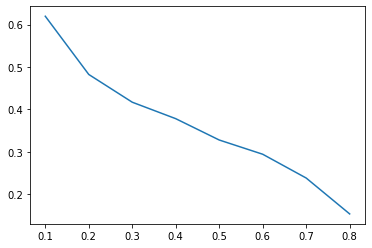

In [90]:
score_list = [fbeta_score(y_test, preds_proba > border, beta=7) for border in np.arange(0.1, 0.9, 0.1)]
plt.plot(np.arange(0.1, 0.9, 0.1), np.array(score_list))

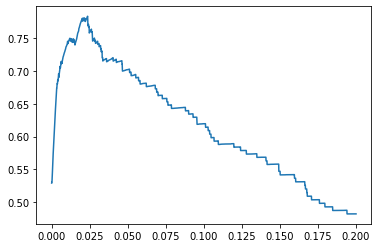

In [91]:
score_list = [fbeta_score(y_test, preds_proba > border, beta=7) for border in np.arange(0.0001, 0.2, 0.0001)]
plt.plot(np.arange(0.0001, 0.2, 0.0001), np.array(score_list))

In [94]:
np.arange(0.0001, 0.2, 0.0001)[np.array(score_list).argmax()]

0.0237

In [95]:
border = 0.0232086940504697
border = np.arange(0.0001, 0.2, 0.0001)[np.array(score_list).argmax()]
preds = preds_proba > border
fbeta_score(y_test, preds, beta=7)

0.7832238504295099

In [20]:
test_cols = list(test_preds_df.columns[test_preds_df.columns.str.contains("preds_mean")])
test_cols = test_cols + pred_cols
test = test_preds_df.loc[:, test_cols]
t_preds = model.predict(test)
output = t_preds > border

In [35]:
sub = pd.read_csv("/content/drive/MyDrive/signate/rawdata/" + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]
sub["judgement"] = output
sub["judgement"] = sub["judgement"].astype(int)
sub.to_csv("/content/drive/MyDrive/signate/data/" + "submission.csv", index=False, header=False)

In [22]:
# 他のモデルの結果と比較
sample = pd.read_csv("/content/drive/MyDrive/signate/results/results_pubmedbert_uncased_title+abstract/" + "submission.csv", header=None)

In [30]:
sample[1].sum()

3159

In [31]:
sub["judgement"].sum()

1449

In [29]:
(sub["judgement"] - sample[1]).abs().sum()

1710